## Prerequisites

This is a simple inference example using Imagenet MobilenetV1 model. To run this examples, you must install the required packages and setup Python environment by following the guides:
* [FuriosaAI Driver, Firmware, Runtime Installation Guide](https://furiosa-ai.github.io/docs/latest/ko/software/installation.html)
* [Setting up a Python Environment](https://furiosa-ai.github.io/docs/latest/ko/software/python-sdk.html#python)

Then, please install the following python packages:
```sh
pip install furiosa-sdk matplotlib pillow
```
Otherwise, you can run the following command to install all dependent packages for notebook examples:
```sh
pip install -r examples/notebooks/requirements.txt
```

In [1]:
from PIL import ImageDraw
from PIL import Image

# Import necessary modules
from furiosa.runtime.sync import create_runner
from helper import load_labels, image_path, show_image
from helper.mobilenet_ssd import *

import time

# SSD Object Detection

In [2]:
%%time
# Load and compile a ssd model for Furiosa'a NPU
ssd_detection = create_runner('models/mscoco_300x300_ssd_mobilenet_v1_uint8_quantization-aware-trained.tflite')

2024-11-05T07:59:31.727765Z  INFO furiosa_rt_core::driver::event_driven::coord: FuriosaRT (v0.10.3, rev: 394c19392, built at: 2023-11-22T08:53:04Z) bootstrapping ...
2024-11-05T07:59:31.730378Z  INFO furiosa_rt_core::driver::event_driven::coord: Found furiosa-compiler (v0.10.1, rev: 8b00177, built at: 2024-05-28T06:18:01Z)
2024-11-05T07:59:31.730383Z  INFO furiosa_rt_core::driver::event_driven::coord: Found libhal (type: warboy, v0.12.0, rev: 56530c0 built at: 2023-11-16T12:34:03Z)
2024-11-05T07:59:31.730386Z  INFO furiosa_rt_core::driver::event_driven::coord: [Runtime-0] detected 1 NPU device(s):
2024-11-05T07:59:31.751672Z  INFO furiosa_rt_core::driver::event_driven::coord: - [0] npu:5:0-1 (warboy-b0-2pe, 128dpes, firmware: 1.7.8, e9f371e)
2024-11-05T07:59:31.751938Z  INFO furiosa_rt_core::driver::event_driven::coord: [Runtime-0] started
2024-11-05T07:59:31.752959Z  INFO furiosa::runtime: Saving the compilation log into /home/changmin/.local/state/furiosa/logs/compiler-20241105165931

In [3]:
ssd_detection.model.print_summary()

Inputs:
{0: TensorDesc(name="normalized_input_image_tensor", shape=(1, 300, 300, 3), dtype=UINT8, format=NHWC, size=270000, len=270000)}
Outputs:
{0: TensorDesc(name="TFLite_Detection_PostProcess", shape=(1, 50, 4), dtype=FLOAT32, format=???, size=800, len=200), 1: TensorDesc(name="TFLite_Detection_PostProcess:1", shape=(1, 50), dtype=FLOAT32, format=??, size=200, len=50), 2: TensorDesc(name="TFLite_Detection_PostProcess:2", shape=(1, 50), dtype=FLOAT32, format=??, size=200, len=50), 3: TensorDesc(name="TFLite_Detection_PostProcess:3", shape=(1,), dtype=FLOAT32, format=?, size=4, len=1)}


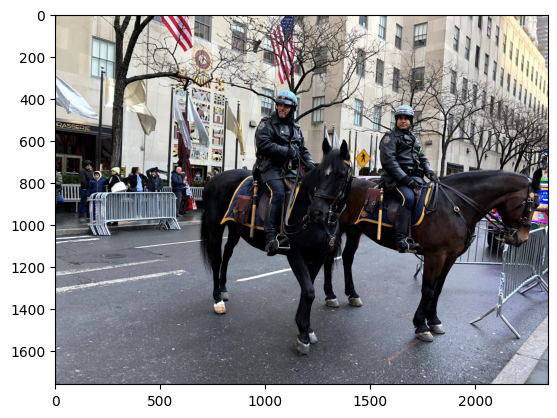

In [4]:
# Load an image

image = Image.open(image_path('street.jpg')).convert('RGB')
show_image(image)

In [5]:
# Resize the image with pads to fit in the model input shape

w_scale, h_scale, data = get_padded_image(ssd_detection, image)

In [6]:
# Let's make sure that the shape of the data is matched to the that of the model input.

print(ssd_detection.model.input(0).shape)
print(data.shape)

(1, 300, 300, 3)
(1, 300, 300, 3)


In [7]:
%%time
# Run a prediction task
outputs = ssd_detection.run(data)

CPU times: user 35.2 ms, sys: 14.1 ms, total: 49.3 ms
Wall time: 22.8 ms


In [8]:
# This model has 4 output tensors. Please refer to the description of output tensors at 
# https://www.tensorflow.org/lite/models/object_detection/overview
len(outputs)

4

### Postprocessing

Let's draw:
1. the rectangles with labels according to the locations, 
1. classification IDs
1. scores from the output tensors

You can learn more about the details about output tensors from https://www.tensorflow.org/lite/models/object_detection/overview#output_signature

person: 98% (box: 1542, 415, 1807, 1143)
horse: 96% (box: 709, 559, 1479, 1578)
horse: 94% (box: 1209, 645, 2303, 1578)
person: 87% (box: 898, 294, 1203, 1161)
person: 72% (box: 426, 726, 491, 851)
person: 65% (box: 290, 729, 359, 844)
person: 50% (box: 561, 722, 638, 906)


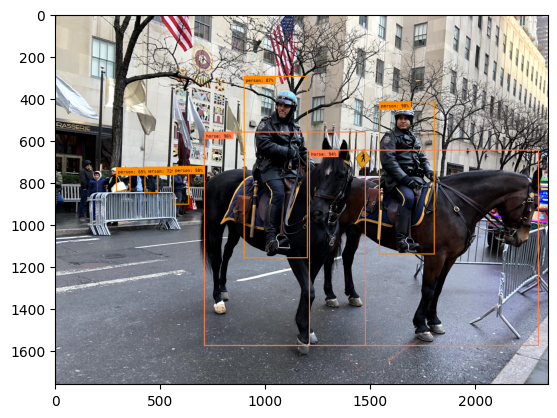

In [9]:
ssd_objects = get_output(ssd_detection, outputs, 0.5, (w_scale, h_scale))
ssd_labels = load_labels('coco_labels.txt')
draw_objects(ImageDraw.Draw(image), ssd_objects, ssd_labels)
show_image(image)
print_objects(ssd_labels, ssd_objects)

In [10]:
ssd_detection.close()

2024-11-05T07:59:33.407642Z  INFO furiosa_rt_core::driver::event_driven::coord: [Sess-51279e3e] terminated
2024-11-05T07:59:33.408173Z  INFO furiosa_rt_core::npu::raw: NPU (npu:5:0-1) has been closed
2024-11-05T07:59:33.408170Z  INFO furiosa_rt_core::driver::event_driven::coord: [Runtime-0] stopped


True